### Basic Application Requirements

In [1]:
# Import necessary models
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
import seaborn as sns
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions as pyspark_functions
from pyspark import SparkContext, SparkConf

### Creating a Spark Session

In [2]:
# Creating spark instance
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

#### Reading the Datasets

In [53]:
# Reading all the datasets (Spark)
col_mat_nuw_data = spark.read.csv("Datasets/col_mat_nuw_output.csv", header=None, inferSchema=True)
kan_output_data = spark.read.csv("Datasets/col_mat_nuw_output.csv", header=None, inferSchema=True)
mon_kur_jaf_output_data = spark.read.csv("Datasets/mon_kur_jaf_output.csv", header=None, inferSchema=True)

In [54]:
# Reading all the datasets (Pandas)
pd_col_mat_nuw = col_mat_nuw_data.toPandas()
pd_kan = kan_output_data.toPandas()
pd_mon_kur_jaf = mon_kur_jaf_output_data.toPandas()

#### Concating 3 datasets into one dataframe

In [55]:
all_city_data = pd.concat([pd_col_mat_nuw, pd_kan, pd_mon_kur_jaf], axis=0)

### Basic Details of the Dataset

##### Dataset of Colombo, Matara and Nuwara

In [56]:
pd_col_mat_nuw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   _c0     3059 non-null   float64
 1   _c1     5478 non-null   object 
 2   _c2     5478 non-null   object 
 3   _c3     5478 non-null   object 
dtypes: float64(1), object(3)
memory usage: 171.3+ KB


In [57]:
pd_kan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   _c0     3059 non-null   float64
 1   _c1     5478 non-null   object 
 2   _c2     5478 non-null   object 
 3   _c3     5478 non-null   object 
dtypes: float64(1), object(3)
memory usage: 171.3+ KB


In [58]:
pd_mon_kur_jaf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   _c0     3826 non-null   float64
 1   _c1     5478 non-null   object 
 2   _c2     5478 non-null   object 
 3   _c3     5478 non-null   object 
dtypes: float64(1), object(3)
memory usage: 171.3+ KB


 It occurs that there are null values in the 1st coloumn (HCHO Reading). Also columns were doesnt named with a meaningful name.

#### Rename Column Names

In [59]:
# Define the new column names
column_names = ['HCHO Reading', 'Location', 'Current Date', 'Next Date']

# Rename the columns
all_city_data.columns = column_names
pd_col_mat_nuw.columns = column_names
pd_kan.columns = column_names
pd_mon_kur_jaf.columns = column_names

In [60]:
all_city_data.head()

,HCHO Reading,Location,Current Date,Next Date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000263,Colombo Proper,2019-01-02,2019-01-03
2,0.000099,Colombo Proper,2019-01-03,2019-01-04
3,0.000210,Colombo Proper,2019-01-04,2019-01-05
4,0.000179,Colombo Proper,2019-01-05,2019-01-06


## Basic Preprocessing

### Colombo, Deniyaya, Matara and Nuwara Eliya Data

##### Finding the null/missing values of the dataset.

In [61]:
pd_col_mat_nuw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HCHO Reading  3059 non-null   float64
 1   Location      5478 non-null   object 
 2   Current Date  5478 non-null   object 
 3   Next Date     5478 non-null   object 
dtypes: float64(1), object(3)
memory usage: 171.3+ KB


In [62]:
# Finding the null values
pd_col_mat_nuw.isnull().sum()

HCHO Reading    2419
Location           0
Current Date       0
Next Date          0
dtype: int64

Basic plot of the HCHO Reading Distribution

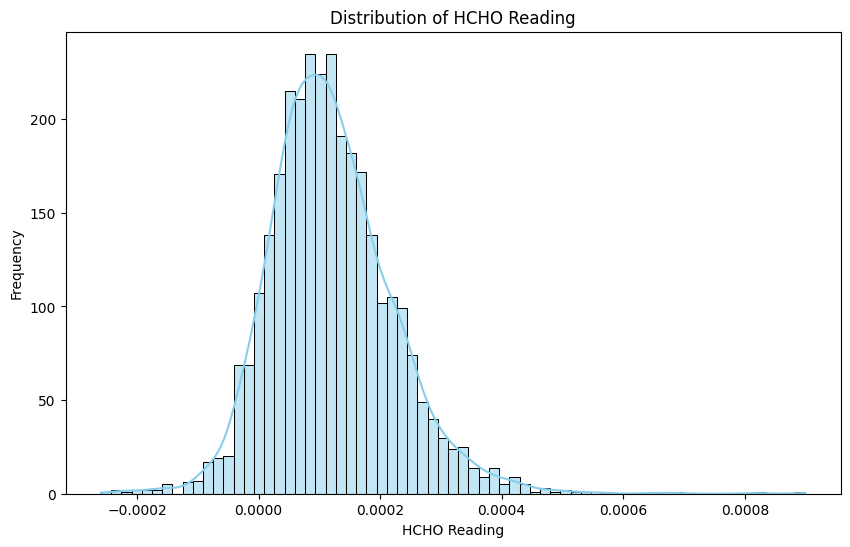

In [63]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(pd_col_mat_nuw["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()

There are 2419 null values from a 5478 dataset. If we remove those null values dataset will be reduced to minimum. Therefore let's fill these values with LOCF and NOCB filling methods. Specially these methods were used because the dataframe is a time series data.

In [64]:
# First apply LOCF
pd_col_mat_nuw.fillna(method='ffill', inplace=True)
# Then apply NOCB
pd_col_mat_nuw.fillna(method='bfill', inplace=True)

C:\Users\Sandin Maheeshakya\AppData\Local\Temp\ipykernel_12936\3661108718.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd_col_mat_nuw.fillna(method='ffill', inplace=True)
C:\Users\Sandin Maheeshakya\AppData\Local\Temp\ipykernel_12936\3661108718.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd_col_mat_nuw.fillna(method='bfill', inplace=True)


In [65]:
# Finding null values after the data filling
pd_col_mat_nuw.isnull().sum()

HCHO Reading    0
Location        0
Current Date    0
Next Date       0
dtype: int64

Now You can see that there are no missing/Null values. Let's see the distribution of the Data feature to check how the distribution goes.

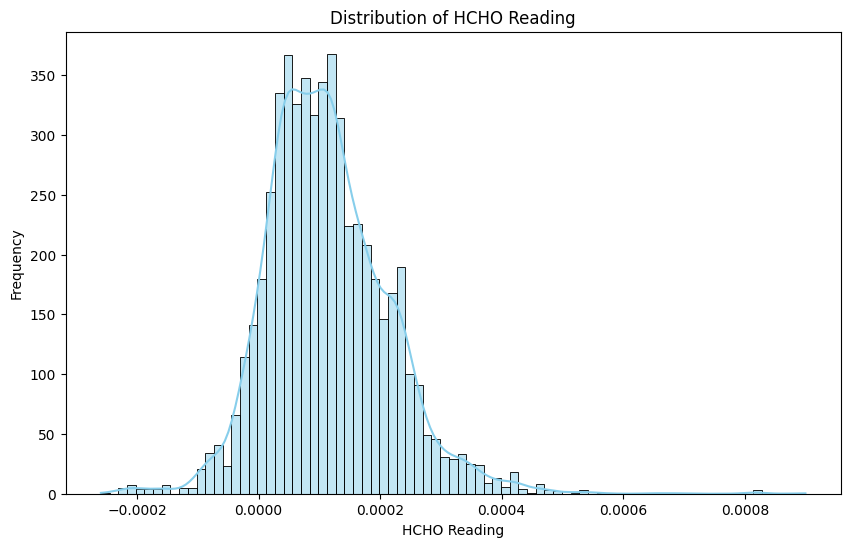

In [66]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(pd_col_mat_nuw["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()

### Duplicate Value Handling

In [67]:
# Finding duplicated records in the dataset
duplicate_rows = pd_col_mat_nuw[pd_col_mat_nuw.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [HCHO Reading, Location, Current Date, Next Date]
Index: []


There is no Duplicate value rows in this dataframe

#### Finding Unique values to find unwanted characters

In [69]:
# Printing each unique value in a column
for column in pd_col_mat_nuw:
    print(column)
    print(pd_col_mat_nuw[column].unique())
    print('\n')

HCHO Reading
[1.96983440e-04 2.62552217e-04 9.85211890e-05 ... 1.07861038e-04
 5.93039927e-06 2.36988212e-04]


Location
['Colombo Proper' 'Deniyaya, Matara' 'Nuwara Eliya Proper']


Current Date
[datetime.date(2019, 1, 1) datetime.date(2019, 1, 2)
 datetime.date(2019, 1, 3) ... datetime.date(2023, 12, 29)
 datetime.date(2023, 12, 30) datetime.date(2023, 12, 31)]


Next Date
[datetime.date(2019, 1, 2) datetime.date(2019, 1, 3)
 datetime.date(2019, 1, 4) ... datetime.date(2023, 12, 30)
 datetime.date(2023, 12, 31) datetime.date(2024, 1, 1)]




There is no unwanted characters in the dataset and all good to go forward this dataframe.

#### Outliers Handling

##### HCHO Outliers Handling

Boxplot to Check the Outliers of the HCHO data

In [36]:
# Create a box plot for HCHO feature
